$$\require{mhchem}$$       

# Gas phase reaction with equilibria

We're interested in optimizing reactor conditions for several competing gas-phase reactions for a feed of $CO$, $O_2$, and $H_2$:
\begin{align*}
\ce{CO + 1/2O2 &<=> CO2}\\
\ce{H2 + 1/2O2 &<=> H2O}\\
\ce{CO + 2H2 &<=> CH4 + 1/2O2}\\
\ce{CO +H2 &<=> CH2O } \text{ (methanal)}\\
\ce{2CO +2H2 &<=> C2H2 + 1/2O2 + H2O } \text{ (acetylene)}
\end{align*}

#### First, determine the free energy for each of the reaction, $\Delta G_0$, at standard state (298 K, 1 atm) using the NIST chemistry webbook. (3 points)

In [2]:
import quantities as u
import numpy as np

#      [  CO,     O2,      CO2,      H2,      H2O,     CH4,    CH2O,    C2H2]
dHf0 = [-110.53,   0.,    -393.51,    0.,    -241.826, -74.87, -115.90, 226.73]*u.joule/u.mol*1000
S0 =   [ 196.66, 205.152,  213.785, 130.680,  188.835, 188.66,  218.95, 200.93]*u.joule/u.mol/u.K

R = 8.3145*u.joule/u.mol/u.K
T = 298*u.K
G = dHf0 - S0*T
stoich = np.array([[-1, -1./2, 1,  0, 0, 0, 0, 0],
                   [ 0, -1./2, 0, -1, 1, 0, 0, 0],
                   [-1,  1./2, 0, -2, 0, 1, 0, 0],
                   [-1,     0, 0, -1, 0, 0, 1, 0],
                   [-2,  1./2, 0, -2, 1, 0, 0, 1]])

dG0j = np.dot(stoich, G)
for j, dG0 in enumerate(dG0j):
    print('Reaction number %i has a dG0 of %i kJ/mol' %(j+1, dG0/1000))

Reaction number 1 has a dG0 of -257 kJ/mol
Reaction number 2 has a dG0 of -228 kJ/mol
Reaction number 3 has a dG0 of 85 kJ/mol
Reaction number 4 has a dG0 of 26 kJ/mol
Reaction number 5 has a dG0 of 254 kJ/mol


#### The chemical potential of an ideal gas species is:
\begin{align}
\mu_i = \Delta G_i = \Delta G_{i,0} + RT\ln[y_iP]
\end{align}
where $y_iP$ is the partial pressure of each species. Evaluate the free energy of each reaction
at 1000 K and 1 atm partial pressure of each species using the shomate equation. Assume that the
shomate equation listed for room temperature (~300 K) applies to higher temperatures as well.
Hint: make sure that whatever you come up with, when evaluated at 298.15K, is close to the
answer above. (3 points)

In [3]:
# one row per species, columns A-H
shomate = np.array(
    [[25.56759, 6.096130, 4.054656, -2.671301, 0.131021, -118.0089, 227.3665, -110.5271], 
     [31.32234, -20.23531, 57.86644, -36.50624, -0.007374, -8.903471, 246.7945, 0.], 
     [24.99735, 55.18696, -33.69137, 7.948387, -0.136638, -403.6075, 228.2431, -393.5224], 
     [33.066178, -11.363417, 11.432816, -2.772874, -0.158558, -9.980797, 172.707974, 0.], 
     [30.092, 6.832514, 6.793435, -2.53448, 0.082139, -250.881, 223.3967, -241.8264], 
     [-0.703029, 108.4773, -42.52157, 5.862788, 0.678565, -76.84376, 158.7163, -74.8731], 
     [5.193767, 93.23249, -44.85457, 7.882279, 0.551175, -119.3591, 202.4663, -115.8972], 
     [40.68697, 40.73279, -16.1784, 3.669741, -0.658411, 210.7067, 235.0052, 226.7314]])  

def dGi(T, Pi):
    '''
    Calculate the chemical potential of a species given the temperature T
    and partial pressure Pi. Since we use np.arrays, we can enter either
    single values for T and Pi or arrays.
    '''
    # Normalize the temperature
    t = float(T.rescale(u.K))/1000
    # Use the shomate equations to correct the enthalpy and entropy
    T_H = np.array([t, t**2/2.0, t**3/3.0, t**4/4.0, -1.0/t, 1.0, 0.0, -1.0])
    T_S = np.array([np.log(t), t, t**2/2.0, t**3/3.0, -1.0/(2.0*t**2), 0.0, 1.0, 0.0])
    H = (np.array(dHf0.rescale(u.joule/u.mol))+np.dot(shomate, T_H)*1000)*u.J/u.mol # J/mol
    S = np.dot(shomate, T_S)*u.joule/u.mol/u.K # J/mol/K
    # Calculate the free energy so that we can use it to calculate the chemical potential
    G0 = H - T*S
    Gi = G0 + R*T*np.log(Pi/(1*u.atm))  # J/mol/K
    return Gi

# Calculate the free energy change at 1000 K and 1 atm for each species
T = 1000.*u.K
Pi = [1]*stoich.shape[1]*u.atm
dGj = np.dot(stoich, dGi(T, Pi))
for j, dG in enumerate(dGj):
    print('Reaction number %i has a dG of %i kJ/mol' %(j+1, dG/1000))

Reaction number 1 has a dG of -195 kJ/mol
Reaction number 2 has a dG of -192 kJ/mol
Reaction number 3 has a dG of 219 kJ/mol
Reaction number 4 has a dG of 112 kJ/mol
Reaction number 5 has a dG of 377 kJ/mol


#### For a mixture of 1 atm total pressure at 1000 K  $CO$, $O_2$, $H_2$ (same starting all species) evaluate the equilibrium constant for each reaction. Use the shomate equation here. (2 points)

In [6]:
# Re-calculate dG0j for the new temperature
T = 1000.*u.K

# Make a new function that calculates standard free energies, but with the Shomate parameters
def dG0j(T):
    ''' Calculate the standard free energy of a species given the temperature T '''
    # Normalize the temperature
    t = float(T.rescale(u.K))/1000
    # Use the shomate equations to correct the enthalpy and entropy
    T_H = np.array([t, t**2/2.0, t**3/3.0, t**4/4.0, -1.0/t, 1.0, 0.0, -1.0])
    T_S = np.array([np.log(t), t, t**2/2.0, t**3/3.0, -1.0/(2.0*t**2), 0.0, 1.0, 0.0])
    H = (np.array(dHf0.rescale(u.joule/u.mol))+np.dot(shomate, T_H)*1000)*u.J/u.mol # J/mol
    S = np.dot(shomate, T_S)*u.joule/u.mol/u.K # J/mol/K
    # Calculate the free energy so that we can use it to calculate the chemical potential
    G0 = H - T*S
    return G0

# Use the function to help calculate equilibrium constant
dG0j = np.dot(stoich, dG0j(T))
Kj = np.exp(-dG0j/R/T)
for j, K in enumerate(Kj):
    print('Reaction number %i has an equilibrium distribution of %.2E' %(j+1, K))

Reaction number 1 has an equilibrium distribution of 1.65E+10
Reaction number 2 has an equilibrium distribution of 1.15E+10
Reaction number 3 has an equilibrium distribution of 3.31E-12
Reaction number 4 has an equilibrium distribution of 1.38E-06
Reaction number 5 has an equilibrium distribution of 1.90E-20


#### Bonus: try to solve for the equilibrium constant (including the entropic term).  You'll probably run into numerical problems unless you try to use a stiff solver. Describe where these problems are coming from. (2 points)

Good luck.

#### What does this say about the reactions? (2 points)

Reactions one and two will dominate the system, as combustion reactions would suggest

# The following reaction data were measured:
\begin{align*}\ce{A + B &<=> C} && E_a=5\: kJ/mol && \Delta G = -10\: kJ/mol\\
\ce{B + C &<=> 2D} && E_a=2\: kJ/mol && \Delta G = -15\: kJ/mol\\
\ce{ B + 2D &<=> 2E} && E_a=10\: kJ/mol && \Delta G = 2\: kJ/mol\\
\end{align*}

#### Calculate the equilibrium constant for each reaction at 1000 K (2 points)

In [4]:
dG0 = [-10, -15, 2]*u.joule/u.mol*1000.
T = 1000.*u.K
K = np.exp(-dG0/R/T)
for j, k in enumerate(K):
    print('Reaction number %i has an equilibrium distribution of %.2f' %(j+1, k))

Reaction number 1 has an equilibrium distribution of 3.33
Reaction number 2 has an equilibrium distribution of 6.07
Reaction number 3 has an equilibrium distribution of 0.79


#### Calculate the equilibrium mole fraction for a system that begins as an equimolar mixture of A,B,C,D,E at 1000 K and 1 atm. Assume isobaric and isothermal conditions. (4 points)

In [5]:
from scipy.optimize import fsolve

# Matrix of stoichiometric coefficients
stoich = np.array([[-1, -1, 1, 0, 0],
                   [0, -1, -1, 2, 0],
                   [0, -1, 0, -2, 2]])
# We define a uniformly distributed, arbitrary vector of the number of moles of each species
ni = stoich.shape[1]    # The number of reactants
nj = stoich.shape[0]    # The number of reactants
N0 = [100./ni]*ni

def N(xj):
    ''' Calculate the moles of each species as a function of the extent of reaction '''
    N = N0 + np.dot(stoich.transpose(), xj)    # moles
    return N

def y(xj):
    ''' Calculate the mole fraction each species as a function of the extent of reaction '''
    y = N(xj)/sum(N(xj))
    return y

def f(xj, K):
    '''
    Create a function to find the vector of reaction extents that yields the equilibrium
    distribution we calculated before
    '''
    # Initialize and populate our current guess for the equilibrium distribution
    # given the extents of each reaction
    kout = np.zeros(len(xj))
    for i in range(len(kout)):
        kout[i] = np.prod(y(xj)**stoich[i])
    return K - kout

# Solve
xj_guess = [0.01]*nj
xj = fsolve(f, xj_guess, K)
yi = y(xj)
species = ['A', 'B', 'C', 'D', 'E']
for i, _y in enumerate(yi):
    print('The mole fraction of species %s is %.2f' %(species[i], _y))

The mole fraction of species A is 0.21
The mole fraction of species B is 0.18
The mole fraction of species C is 0.12
The mole fraction of species D is 0.36
The mole fraction of species E is 0.13


#### Plot the equilibrium extent of each reaction (moles) as a function of temperature from 800 K to 1000 K (4 points)

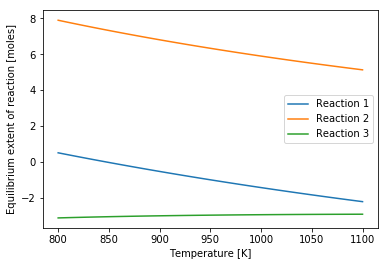

In [6]:
# We'll store our vectors of reaction extents in a list, `xj_save`
xj_save = []
# Let's define our range to calculate over
Trange = np.linspace(800, 1100, 100)

# Do the same calculations we've been doing
for t in Trange:
    T = t*u.K
    K = np.exp(-dG0/R/T)
    xj_guess = [0.01]*nj
    xj = fsolve(f, xj_guess, K)
    xj_save.append(xj)
    
import matplotlib.pyplot as plt
plt.plot(Trange, xj_save)
plt.xlabel('Temperature [K]')
plt.ylabel('Equilibrium extent of reaction [moles]')
plt.legend(['Reaction 1', 'Reaction 2', 'Reaction 3'])
plt.show()